# SVR Training
The labels in this case indicate the intensity of a certain AU.
https://pythonprogramming.net/training-testing-machine-learning-tutorial/

***

Some general tests. <br> Note: in CK+ dataset if the AU intensity is 0, it means that the AU is present in the frame but its intensity wasn't recorded. In these cases we consider 2 as intensity (in a scale between 0 and 5).

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from face_helpers import get_face_locations, get_landmarks, align_and_crop, get_hog_features, show_gray_image, show_image_from_path
import numpy as np


def show_gray_image_from_path(path):
    img = mpimg.imread(path)    
    imgplot = plt.imshow(img, cmap=plt.cm.gray)
    plt.show()
    
def change_extension_to_txt(text):
    return text[:-4] + "_facs.txt"
    
def get_aus(label_path, subpath):
    img_aus = dict()  # lista delle AU della singola immagine
    fname = "{}/{}".format(label_path, change_extension_to_txt(subpath))
    if os.path.isfile(fname):  # se il file esiste
        f = open(fname,"r") 
        for line in f: 
            intensity = int(float(line.split()[1])) if float(line.split()[1]) != 0.0 else 2
            img_aus[int(float(line.split()[0]))] = intensity
    return img_aus

dataset/CK+/cohn-kanade-images/S005/001/S005_001_00000011.png
AU: {9: 4, 17: 2}


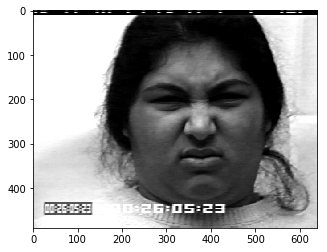

In [3]:
frame_path = "dataset/CK+/cohn-kanade-images"
label_path = "dataset/CK+/FACS"

print("dataset/CK+/cohn-kanade-images/S005/001/S005_001_00000011.png")
print("AU: {}".format(get_aus(label_path, "S005/001/S005_001_00000011.txt"))) 
show_gray_image_from_path("dataset/CK+/cohn-kanade-images/S005/001/S005_001_00000011.png")

In [4]:
def apply_pipeline(path, return_hog_image=False):
    img = get_face_locations(path, verbose=False)
    landmarks, _ = get_landmarks(img)
    img = align_and_crop(img, landmarks)
    return get_hog_features(img, flat_vector=True, return_image=return_hog_image)

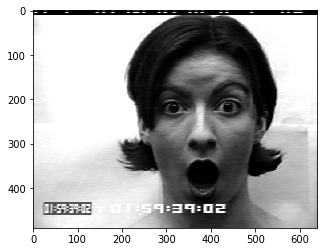

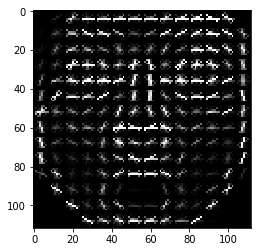

dataset/CK+/cohn-kanade-images/S010/002/S010_002_00000014.png     1
AU: {1: 2, 2: 2, 5: 2, 25: 2, 27: 2}
-------------------------------------------------------------------
dataset/CK+/cohn-kanade-images/S011/001/S011_001_00000016.png     2
AU: {1: 2, 2: 2, 25: 2, 27: 2}
-------------------------------------------------------------------
dataset/CK+/cohn-kanade-images/S014/001/S014_001_00000029.png     3
AU: {1: 2, 2: 2, 5: 2, 12: 2, 25: 2, 27: 2}
-------------------------------------------------------------------
...
Shape della matrice di feature:  (162, 6084)
Numero di etichette:             162


In [82]:
au = 27
aus_list = dict()
feature_list = list()
labels = list()
count_positive = 0
count_negative = 0

for dir in os.listdir(frame_path):
    for subdir in os.listdir("{}/{}".format(frame_path, dir)):
        if not subdir.startswith('.'):
            for frame in os.listdir("{}/{}/{}".format(frame_path, dir, subdir)):
                if frame.endswith(".png"):
                    aus_list = get_aus(label_path, "{}/{}/{}".format(dir, subdir, frame))         
                    if au in aus_list.keys():  
                        if count_positive == 0:
                            fd, hog_image = apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame), return_hog_image=True)
                            show_gray_image_from_path("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                            show_gray_image(hog_image)
                        else:
                            fd = apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                
                        if count_positive < 3:
                            print("{}/{}/{}/{}     {}".format(frame_path, dir, subdir, frame, count_positive+1))
                            print("AU: {}".format(aus_list))
                            print("-------------------------------------------------------------------")
                        if count_positive == 3:
                            print("...")
                            
                        count_positive += 1
                        feature_list.append(fd)
                        labels.append(aus_list[au])
                    
                    else:
                        if count_positive > count_negative:
                            count_negative += 1
                            feature_list.append(apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame)))
                            labels.append(0) 
                    
feature_list = np.asarray(feature_list)
print("Feature matrix shape: ", feature_list.shape)
print("Number of labels:     ", len(labels))

In [5]:
def get_accuracy(predicted_labels, true_labels):
    counter_ok = 0.0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == true_labels[i]:
            counter_ok += 1
    return counter_ok

In [6]:
from sklearn.externals import joblib
models_path = "models"

def save_model(model, name):
    joblib.dump(model, "{}/{}".format(models_path, name))
    
def load_model(name):
    return joblib.load("{}/{}".format(models_path, name))

<br>
SVRs Training.

In [7]:
def add_data(au, feature_list, labels, frame_path, label_path):
    aus_list = list()
    global count_positive
    global count_negative

    for dir in os.listdir(frame_path):
        for subdir in os.listdir("{}/{}".format(frame_path, dir)):
            if not subdir.startswith('.'):
                for frame in os.listdir("{}/{}/{}".format(frame_path, dir, subdir)):
                    if frame.endswith(".png"):
                        aus_list = get_aus(label_path, "{}/{}/{}".format(dir, subdir, frame))                    
                        if au in aus_list.keys():  
                            try:
                                fd = apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                                count_positive += 1
                                feature_list.append(fd)
                                labels.append(aus_list[au])
                            except:
                                pass
                        
                        else:
                            if count_positive > count_negative:
                                try:
                                    count_negative += 1
                                    feature_list.append(apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame)))
                                    labels.append(0)
                                except:
                                    pass

In [28]:
import csv
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold


#aus = [1, 2, 4, 5, 6, 7, 9, 12, 14, 15, 16, 20, 23, 26]
aus = [23]
scaler = StandardScaler()
file = open("scores.csv", 'a', newline='')
wr = csv.writer(file)

# OpenFace come griglia di iperparametri usa:
#      - C = [10.^(-7:0.5:1);]
#      - Gamma = [0.001]
param_grid = {'C': [100, 10, 1, 0.1, 0.01], 'gamma': [0.001]}
cv = KFold(n_splits=5, shuffle=True)



for au in aus:
    print("AU: ", au)
    count_positive = 0
    count_negative = 0
    feature_list = list()
    labels = list()
    print("     - Add data from {}...".format("CK+"))
    add_data(au, feature_list, labels, frame_path = "dataset/CK+/cohn-kanade-images", label_path = "dataset/CK+/FACS") 
    print("     - Add data from {}...".format("UNBC"))
    add_data(au, feature_list, labels, frame_path = "dataset/UNBC-pain/Images", label_path = "dataset/UNBC-pain/Frame_Labels/FACS")
    feature_list = np.asarray(feature_list)
    print("          Feature matrix shape: ", feature_list.shape)
    print("          Number of labels:     ", len(labels))
    
    
    print("     - Division of data in Training and Test sets...")
    X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_list, labels, test_size=0.2, random_state=0)
    print("          X_train: {} \n          X_test:  {}".format(X_train.shape, X_test.shape))
    
    
    print("     - PCA transformation...")
    pca = PCA(n_components=.95)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("          X_train: {} \n          X_test:  {}".format(X_train_pca.shape, X_test_pca.shape))
    
    
    print("     - K-Fold Validation for the hyperparameter C...")
    scaler = StandardScaler()
    scaler.fit(X_train_pca)
    X_train_pca = scaler.transform(X_train_pca)
    X_test_pca = scaler.transform(X_test_pca)
    clf_grid = GridSearchCV(SVR(), param_grid, cv=cv, n_jobs=-1)
    clf_grid.fit(X_train_pca, y_train)
    print("          Best Parameters: ", clf_grid.best_params_)
    
    
    print("     - SVR training...")
    clf = clf_grid.best_estimator_
    clf.fit(X_train_pca, y_train)
    
    predicted_labels = clf.predict(X_test_pca)               
    test_score = clf.score(X_test_pca, y_test)
    print("          Test Score  -> {:.2f} %".format(test_score*100))

    predicted_labels = clf.predict(X_train_pca)
    train_score = clf.score(X_train_pca, y_train)
    print("          Train Score -> {:.2f} %".format(train_score*100))

    #wr.writerow(["model", "count_ok_train", "count_tot_train", "train_score", "count_ok_test", "count_tot_test", "test_score"])
    wr.writerow(["svr_au{}".format(au), train_score, test_score])
    
    print("     - Save the models...")
    save_model(pca, "pca_au{}-svr".format(au))
    save_model(clf, "svr_au{}".format(au))
    save_model(scaler, "scaler_au{}-svr".format(au))
    print("--------------------------------------------------------")
    
file.close()

AU:  23
     - Aggiungo i dati da CK+...
     - Aggiungo i dati da UNBC...
          Shape della matrice di feature:  (120, 6084)
          Numero di etichette:             120
     - Suddivido i dati in Training e Test set...
          X_train: (96, 6084) 
          X_test:  (24, 6084)
     - Riduco la dimensionalità dei dati...
          X_train: (96, 81) 
          X_test:  (24, 81)
     - Valido i parametri C e Gamma...
          Best Parameters:  {'C': 10, 'gamma': 0.001}
     - Addestro la SVR...
          Test Score  -> 20.77 %
          Train Score -> 81.87 %
     - Salvo i modelli...
--------------------------------------------------------


<br>
Test and Training scores.

In [30]:
with open('scores.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0][:3] == "svr":
            print("{}:\n     Test Score  -> {:.2f} %\n     Train Score -> {:.2f} %\n"\
                 .format(row[0], float(row[2])*100, float(row[1])*100))

svr_au23:
     Test Score  -> 20.77 %
     Train Score -> 81.87 %

